<a href="https://colab.research.google.com/github/prunuspadus/0_git_basics/blob/master/%D0%9C%D0%B8%D0%BD%D0%B0%D0%B5%D0%B2%D0%B0_%D0%98%D0%9422_1_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [301]:
df = pd.read_csv('/content/index.csv')
print(f"Строки: {df.shape[0]}")
print(f"Столбцы: {df.shape[1]}")
print(df.dtypes)

Строки: 2341
Столбцы: 6
date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


In [302]:
df.head(5)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


# Предобработка данных

In [303]:
# Удалим все лишние пробелы из имен столбцов
df.columns = df.columns.str.strip()

# Преобразуем 'date' и 'datetime' в объекты datetime
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['datetime'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2341 non-null   datetime64[ns]
 1   datetime     2341 non-null   datetime64[ns]
 2   cash_type    2341 non-null   object        
 3   card         2252 non-null   object        
 4   money        2341 non-null   float64       
 5   coffee_name  2341 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 109.9+ KB


In [304]:
df.duplicated().sum()

0

In [305]:
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


In [306]:
# Обработка пропусков в столбце card
df['card'].fillna('Не указано', inplace=True)  # Заполнение пропусков

In [307]:
df_norm = df.copy()
df_norm['hour'] = df_norm['datetime'].dt.hour
df_norm['day_of_week'] = df_norm['datetime'].dt.dayofweek

In [308]:
# One-Hot Encoding для coffee_name
one_hot = pd.get_dummies(df_norm['coffee_name'], prefix='coffee')
one_hot = one_hot.astype(int)

In [309]:
df_norm = pd.concat([df_norm, one_hot], axis=1)
df_norm.drop('coffee_name', axis=1, inplace=True)
df_norm.head(5)

,date,datetime,cash_type,card,money,hour,day_of_week,coffee_Americano,coffee_Americano with Milk,coffee_Cappuccino,coffee_Cocoa,coffee_Cortado,coffee_Espresso,coffee_Hot Chocolate,coffee_Latte
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,10,4,0,0,0,0,0,0,0,1
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,12,4,0,0,0,0,0,0,1,0
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,12,4,0,0,0,0,0,0,1,0
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,13,4,1,0,0,0,0,0,0,0
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,13,4,0,0,0,0,0,0,0,1


Нормализация money

In [310]:
scaler = MinMaxScaler()
df_norm['money'] = scaler.fit_transform(df_norm[['money']])
df_norm['money']

,money
0,0.940585
1,0.940585
2,0.940585
3,0.492687
4,0.940585
...,...
2336,0.806216
2337,0.582267
2338,0.806216
2339,0.806216


# Описательный анализ <a class="anchor"  id="chapter1"></a>

In [311]:
df.describe()

,date,datetime,money
count,2341,2341,2341.000000
mean,2024-07-25 14:24:51.670226432,2024-07-26 05:13:19.630455296,31.816736
min,2024-03-01 00:00:00,2024-03-01 10:15:50.520000,18.120000
25%,2024-05-24 00:00:00,2024-05-24 18:17:40.329999872,27.920000
50%,2024-08-05 00:00:00,2024-08-05 09:19:19.176000,32.820000
75%,2024-10-01 00:00:00,2024-10-01 12:14:23.382000128,35.760000
max,2024-11-16 00:00:00,2024-11-16 14:25:47.388000,40.000000
std,NaN,NaN,5.094530


## Матрица корреляций

In [312]:
label_encoder = preprocessing.LabelEncoder()

update_df = df.copy()

update_df['datetime'] = label_encoder.fit_transform(update_df['datetime'])
update_df['cash_type'] = label_encoder.fit_transform(update_df['cash_type'])
update_df['card'] = label_encoder.fit_transform(update_df['card'])
update_df['money'] = label_encoder.fit_transform(update_df['money'])
update_df['coffee_name'] = label_encoder.fit_transform(update_df['coffee_name'])

<Axes: >

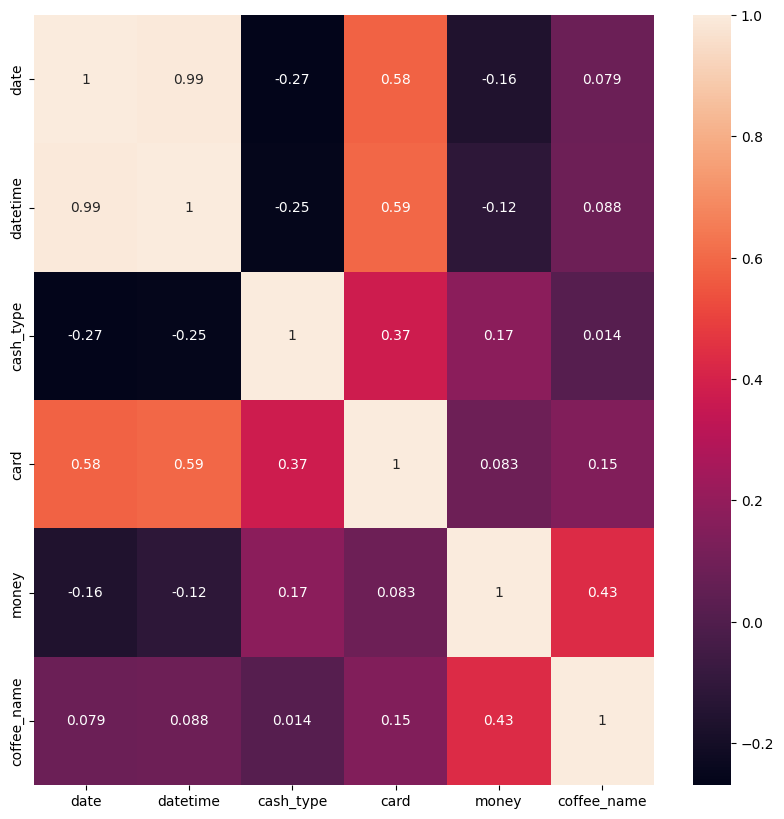

In [313]:
plt.figure(figsize=(10,10), linewidth=.5)
sns.heatmap(update_df.corr(), annot=True)

## Визуализация ежедневных продаж

In [314]:
# Повторная выборка по дням и расчет ежедневных продаж
daily_sales = df.groupby('date')['money'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)  # Ensure the index has a daily frequency.
print(f"Number of days: {daily_sales.shape[0]}")
daily_sales.head(3)

Number of days: 261


,money
date,
2024-03-01,396.3
2024-03-02,228.1
2024-03-03,349.1


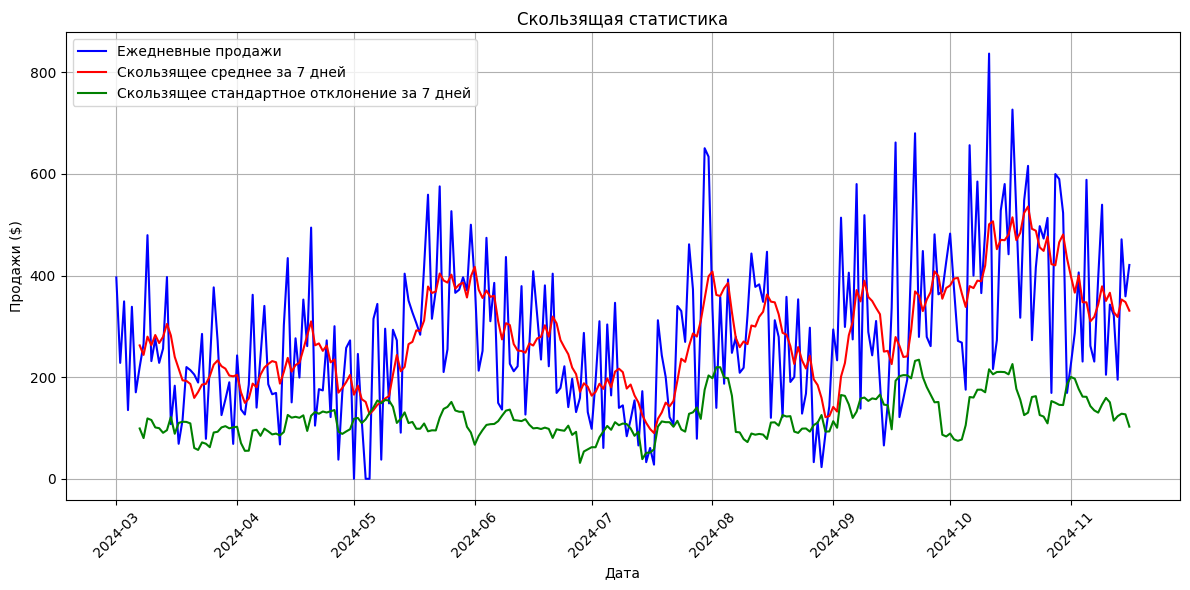

In [315]:
rolling_mean = daily_sales.rolling(window=7).mean()
rolling_std = daily_sales.rolling(window=7).std()

plt.figure(figsize=(12, 6))
plt.plot(daily_sales, label='Ежедневные продажи', color='blue')
plt.plot(rolling_mean, label='Скользящее среднее за 7 дней', color='red')
plt.plot(rolling_std, label='Скользящее стандартное отклонение за 7 дней', color='green')
plt.title('Скользящая статистика')
plt.xlabel('Дата')
plt.ylabel('Продажи ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

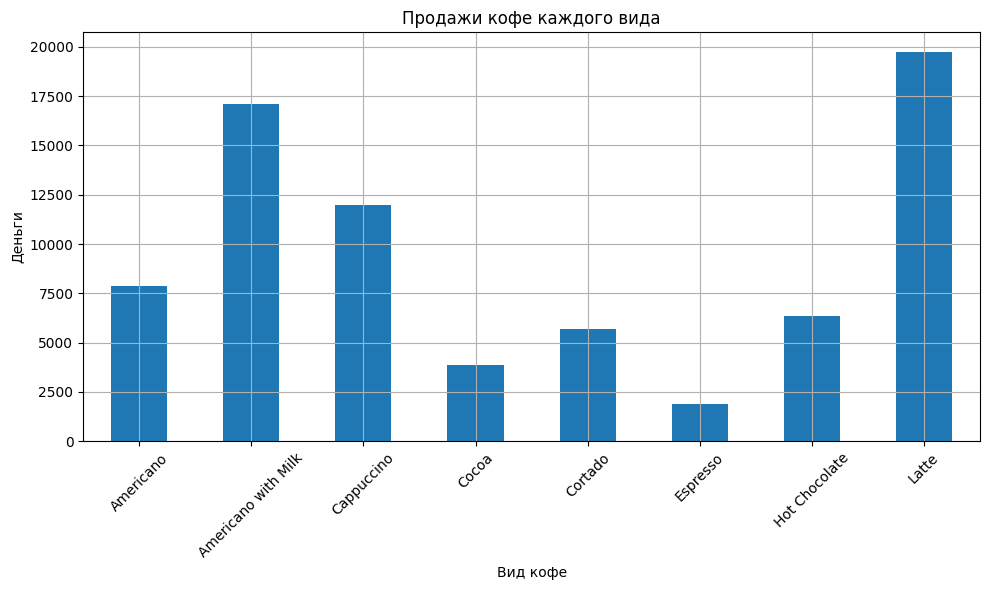

In [316]:
sales_by_coffee_type = df.groupby('coffee_name')['money'].sum()

plt.figure(figsize=(10, 6))
sales_by_coffee_type.plot(kind='bar')
plt.title('Продажи кофе каждого вида')
plt.xlabel('Вид кофе')
plt.ylabel('Деньги')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

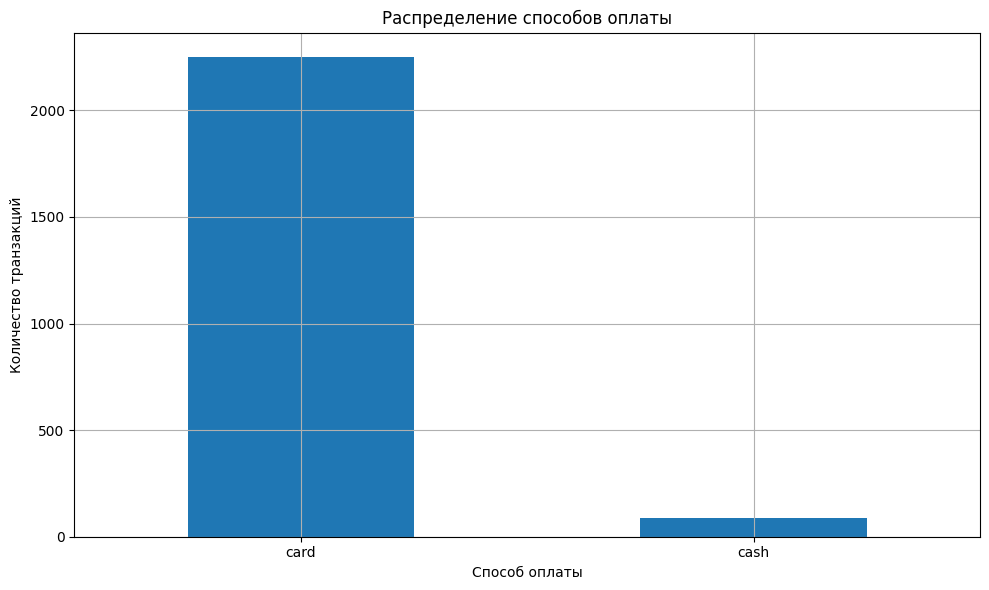

In [317]:
payment_distribution = df['cash_type'].value_counts()

plt.figure(figsize=(10, 6))
payment_distribution.plot(kind='bar')
plt.title('Распределение способов оплаты')
plt.xlabel('Способ оплаты')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

## Декомпозиция временных рядов

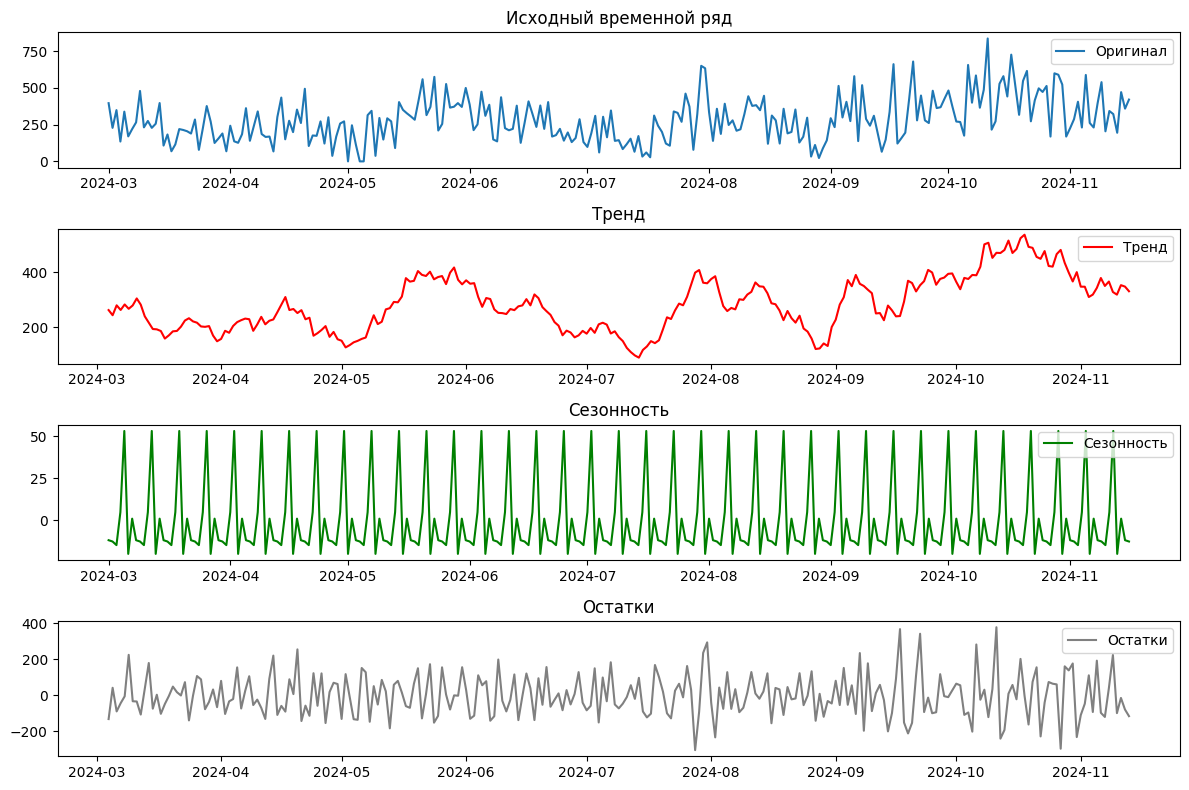

In [318]:
decomposition = seasonal_decompose(daily_sales, model='add')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(daily_sales, label='Оригинал')
plt.title('Исходный временной ряд')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Тренд', color='red')
plt.title('Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Сезонность', color='green')
plt.title('Сезонность')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Остатки', color='gray')
plt.title('Остатки')
plt.legend()

plt.tight_layout()
plt.show()

In [319]:
daily_sales = df.groupby('date')['money'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)  # Ensure the index has a daily frequency.
print(f"Количество дней: {daily_sales.shape[0]}")
daily_sales.head(3)

Количество дней: 261


,money
date,
2024-03-01,396.3
2024-03-02,228.1
2024-03-03,349.1


# Моделирование <a class="anchor"  id="chapter2"></a>

# ARIMA & SARIMAX

## Проверка на стационарность

In [320]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [321]:
def interpret_adfuller_test(pvalue, sig_level):
    if pvalue < sig_level:
        return "Отвергаем H_0: ряд стационарный!"
    return "Не отвеграем H_0: ряд не стационарный!"

In [322]:
SIGNIFICANCE_LEVEL = 0.05 # уровень значимости

result = adfuller(df_norm['money'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(interpret_adfuller_test(result[1], SIGNIFICANCE_LEVEL))

ADF Statistic: -3.1329517105873896
p-value: 0.024208786914566897
Отвергаем H_0: ряд стационарный!


## Определение параметров для моделей

In [323]:
seasonal_diff = daily_sales.diff(7).dropna()
seasonal_diff.head(3)

,money
date,
2024-03-08,-130.8
2024-03-09,251.3
2024-03-10,-117.5


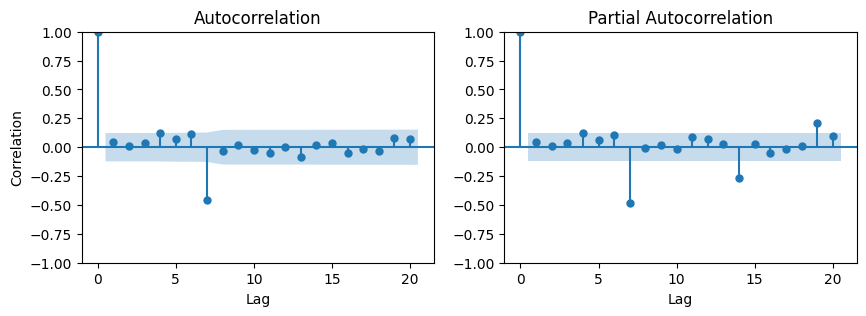

In [324]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(seasonal_diff, lags=20, ax=axes[0])
plot_pacf(seasonal_diff, lags=20, ax=axes[1])
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Correlation')
axes[1].set_xlabel('Lag')
plt.show()

## Выделение обучающей и тестовой выборки

In [325]:
results = {}
predictions ={}

In [326]:
# Обработка данных
X = df_norm[['hour', 'day_of_week', 'coffee_Americano', 'coffee_Americano with Milk',
              'coffee_Cappuccino', 'coffee_Cocoa', 'coffee_Cortado',
              'coffee_Espresso', 'coffee_Hot Chocolate', 'coffee_Latte']]
X = X.apply(pd.to_numeric)

y = df_norm['money']

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [328]:
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((1872, 10), (469, 10), (1872,), (469,))

## Обучение модели ARIMA

In [329]:
# Параметры
p, d, q = 3, 1, 0

In [330]:
# Обучение моделей ARIMA и SARIMAX
# Предполагаем, что y является временным рядом
y_train_arima = y[:len(y_train)]
y_test_arima = y[len(y_train):]

# Обучение модели ARIMA
arima_model = ARIMA(y_train_arima, order=(p, d, q))  # Параметры (p, d, q) могут быть изменены
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(y_test_arima))

## Оценка качества ARIMA

In [331]:
results['ARIMA'] = {
    'MAE': mean_absolute_error(y_test_arima, arima_pred),
    'MSE': mean_squared_error(y_test_arima, arima_pred),
    'R²': r2_score(y_test_arima, arima_pred)
}
print(results['ARIMA'])

{'MAE': 0.1848223431508618, 'MSE': 0.04306003232296461, 'R²': -0.2077741786093903}


### Подбор параметров модели с помощью auto_arima

In [332]:
pip install pmdarima

In [333]:
from pmdarima import auto_arima

In [ ]:
# Подбор параметров модели с помощью auto_arima
stepwise_fit = auto_arima(y_train_arima, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',   # игнорировать неудачные порядки
                           suppress_warnings=True,  # игнорировать предупреждения о сходимости
                           stepwise=True)           # использовать пошаговый подход

# Печать сводки по подобранной модели
print(stepwise_fit.summary())

# Получение оптимальных параметров p, d, q
p, d, q = stepwise_fit.order

# Создание и подгонка модели ARIMA с подобранными параметрами
model = ARIMA(y_train_arima, order=(p, d, q))
model_fit = model.fit()

# Печать сводки по подогнанной модели
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=16.12 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1751.377, Time=0.22 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=844.970, Time=1.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=16.90 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1409.673, Time=0.94 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=627.694, Time=6.79 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=15.37 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=997.487, Time=0.70 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=426.689, Time=2.90 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=646.237, Time=1.70 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=10.52 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=8.19 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=330.831, Time=1.54 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=544.790, Time=1.31 sec


## Обучение модели SARIMAX

In [ ]:
# Параметры
p, d, q = 5, 1, 0
P, D, Q, s = 2, 1, 0, 7

In [ ]:
sarimax_model = SARIMAX(y_train_arima, order=(p, d, q), seasonal_order=(P, D, Q, s))  # Параметры могут быть изменены
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.forecast(steps=len(y_test_arima))

## Оценка качества SARIMAX

In [ ]:
results['SARIMAX'] = {
    'MAE': mean_absolute_error(y_test_arima, sarimax_pred),
    'MSE': mean_squared_error(y_test_arima, sarimax_pred),
    'R²': r2_score(y_test_arima, sarimax_pred)
}
print(results['SARIMAX'])

### Подбор параметров модели с помощью auto_arima

In [ ]:
# Подбор параметров модели с помощью auto_arima
stepwise_fit = auto_arima(y_train_arima, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',   # игнорировать неудачные порядки
                           suppress_warnings=True,  # игнорировать предупреждения о сходимости
                           stepwise=True)           # использовать пошаговый подход

# Печать сводки по подобранной модели
print(stepwise_fit.summary())

# Получение оптимальных параметров p, d, q
p, d, q = stepwise_fit.order
# Если модель сезонная, также получаем параметры P, D, Q, s
P, D, Q, s = stepwise_fit.seasonal_order

# Создание и подгонка модели SARIMAX с подобранными параметрами
model = SARIMAX(y_train_arima, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

# Печать сводки по подогнанной модели
print(model_fit.summary())

## Генерация прогнозов для ARIMA и SARIMAX на 7 дней

In [ ]:
future_arima_data = y[-30:]  # Используем последние 30 значений для прогноза
arima_future_pred = arima_fit.forecast(steps=7 * 24)  # Прогноз на 7 дней по 24 часа
sarimax_future_pred = sarimax_fit.forecast(steps=7 * 24)  # Прогноз на 7 дней по 24 часа

# Добавление прогнозов ARIMA и SARIMAX в общий словарь прогнозов
predictions['ARIMA'] = arima_future_pred.to_numpy()
predictions['SARIMAX'] = sarimax_future_pred.to_numpy()

# Другие модели

In [ ]:
# Группировка данных по дате и суммирование 'money'
history_sales = df_norm.groupby('date')['money'].sum().reset_index()

# Преобразование столбца 'date' в datetime
history_sales['date'] = pd.to_datetime(history_sales['date'])

print(f"Number of days: {history_sales.shape[0]}")

# Вывод названий столбцов
print(history_sales['date'].max())

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
}

In [ ]:
# Обучение моделей и получение прогнозов на тестовой выборке
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'MSE': mse, 'R²': r2}

    # Генерация данных для прогноза на 7 дней
    last_date = history_sales['date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)
    future_data = []

    for date in future_dates:
        for hour in range(24):  # Прогнозируем для каждого часа в течение 7 дней
            future_data.append([hour, date.dayofweek] + [0] * (X.shape[1] - 2))  # Замените 0 на реальные значения кофе

    future_df = pd.DataFrame(future_data, columns=X.columns)
    future_predictions = model.predict(future_df)
    predictions[name] = future_predictions

In [ ]:
# Оценка результатов
results_df = pd.DataFrame(results).T
print("\nРезультаты оценки модели:\n", results_df)

In [ ]:
# Агрегация прогнозов по дням
aggregated_predictions = {name: preds.reshape(7, 24).sum(axis=1) for name, preds in predictions.items()}

# Визуализация прогнозов
plt.figure(figsize=(15, 10))
for name, preds in aggregated_predictions.items():
    plt.plot(range(1, 8), preds, label=name)

plt.title('Прогноз продаж на 7 дней')
plt.xlabel('День')
plt.ylabel('Продажи')
plt.xticks(range(1, 8), [f'Day {i}' for i in range(1, 8)])
plt.legend()
plt.grid()
plt.show()

In [ ]:
best_model_name = results_df['R²'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7, label='Предсказанные')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label='Идеальные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title(f'{best_model_name}: Фактическое и Предсказанное')
plt.legend()
plt.show()

In [ ]:
# Создание DataFrame для прогнозов
predicted_sales_df = pd.DataFrame({
    'date': future_dates,
    'money': aggregated_predictions['Gradient Boosting']
})
predicted_sales_df

In [ ]:
# Объединение реальных данных с прогнозами
combined_sales_df = pd.concat([history_sales, predicted_sales_df], ignore_index=True)

In [ ]:
# Визуализация
plt.figure(figsize=(15, 8))
plt.plot(history_sales['date'], history_sales['money'], label='Реальные продажи', color='blue')
plt.plot(predicted_sales_df['date'], predicted_sales_df['money'], label='Прогнозируемые продажи', color='orange')

plt.title('Реальные и прогнозируемые продажи')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()